### Injury Risk Classification on FIFA Dataset

This notebook builds a binary classification model to predict whether a player had a significant injury in the previous season. We use the `significant_injury_prev_season` column as our target label and train logistic regression, random forest, and XGBoost classifiers. Performance is evaluated using precision, recall, F1-score, and AUC-ROC.



In [15]:
#import required libraries for classification, visualization, and evaluation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve


In [16]:
#load the cleaned and feature-enhanced fifa dataset
df = pd.read_csv("/content/cleaned_fifa_dataset_v3_with_features.csv")
df.head()


,p_id2,start_year,season_days_injured,total_days_injured,season_minutes_played,season_games_played,season_matches_in_squad,total_minutes_played,total_games_played,dob,...,bmi,work_rate_numeric,position_numeric,significant_injury_prev_season,cumulative_days_injured,season_days_injured_prev_season,injury_rate,minutes_per_game,experience_years,bmi_class
0,aaronconnolly,2019,13,161,1312.0,24,28,2148.0,41,2000-01-28,...,24.613627,2.5,2.0,NaN,NaN,NaN,3.833333,52.480000,19,Normal
1,aaronconnolly,2020,71,161,836.0,17,28,2148.0,41,2000-01-28,...,24.613627,2.5,2.0,0.0,161.0,13.0,3.833333,46.444444,20,Normal
2,aaroncresswell,2016,95,226,2247.0,26,27,13368.0,149,1989-12-15,...,22.396079,3.5,1.0,NaN,NaN,NaN,1.506667,83.222222,27,Normal
3,aaroncresswell,2018,87,226,1680.0,20,27,13368.0,149,1989-12-15,...,22.396079,3.5,1.0,0.0,226.0,95.0,1.506667,80.000000,29,Normal
4,aaroncresswell,2019,35,226,2870.0,31,31,13368.0,149,1989-12-15,...,22.396079,3.5,1.0,0.0,452.0,87.0,1.506667,89.687500,30,Normal


We now define our target variable: whether the player got injured within the next 30 days. This can be inferred from `season_days_injured` or other injury-related fields if not already binary.
Let’s assume we classify players as **injured (1)** if `season_days_injured` > 0, otherwise **not injured (0)**.

In [17]:
#use 'significant_injury_prev_season' as the binary classification label
#1 means the player had a significant injury last season; 0 means they did not
df['injury_label'] = df['significant_injury_prev_season']


Now that we have a target label (`injury_label`), we select relevant input features for classification. We'll choose physical, performance, and movement-based features like `age`, `bmi`, `avg_days_injured_prev_seasons`, etc.

In [18]:
#select relevant features to predict injury risk
features = [
    'age',
    'bmi',
    'avg_days_injured_prev_seasons',
    'avg_games_per_season_prev_seasons',
    'cumulative_days_injured',
    'season_days_injured_prev_season'
]

#drop rows with missing values from selected features and label
df_class = df[features + ['injury_label']].dropna()


In [19]:
#define feature matrix X and label y
X = df_class[features]
y = df_class['injury_label']


In [20]:
#split the dataset into training and testing sets using stratified sampling to preserve class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


We now train three classifiers:

1. Logistic Regression (baseline)

2. Random Forest Classifier

3. XGBoost Classifier

In [21]:
#standardize the input features to improve model convergence and stability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [22]:
#initialize and train logistic regression model
lr = LogisticRegression()
lr.fit(X_train_scaled, y_train)

#initialize and train random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

#initialize and train xgboost classifier
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:13:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [23]:
#define evaluation function for all models using classification metrics and ROC-AUC
def evaluate_classifier(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"🔍 {model_name} Results")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC-ROC Score: {auc:.4f}")
    print("-" * 50)


🔍 Logistic Regression Results
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       108
         1.0       1.00      0.91      0.95        32

    accuracy                           0.98       140
   macro avg       0.99      0.95      0.97       140
weighted avg       0.98      0.98      0.98       140



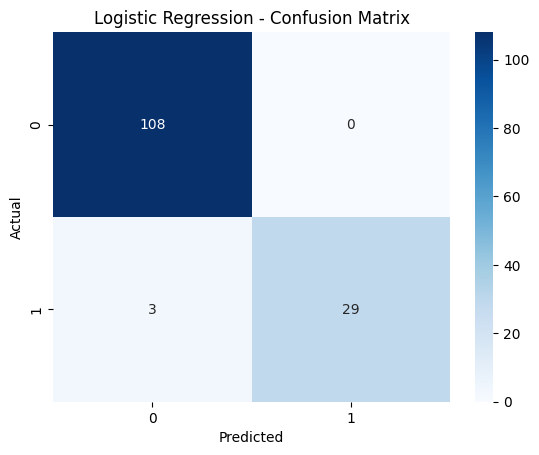

AUC-ROC Score: 1.0000
--------------------------------------------------
🔍 Random Forest Results
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       108
         1.0       1.00      1.00      1.00        32

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



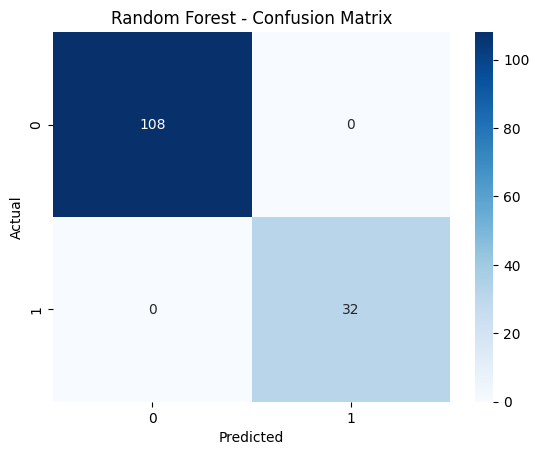

AUC-ROC Score: 1.0000
--------------------------------------------------
🔍 XGBoost Results
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       108
         1.0       1.00      1.00      1.00        32

    accuracy                           1.00       140
   macro avg       1.00      1.00      1.00       140
weighted avg       1.00      1.00      1.00       140



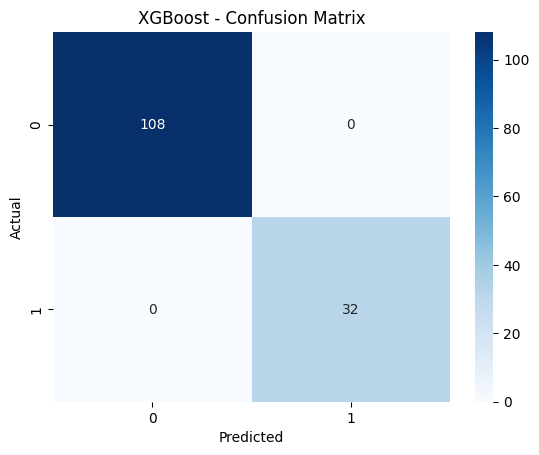

AUC-ROC Score: 1.0000
--------------------------------------------------


In [24]:
#evaluate all classifiers using the defined evaluation function
evaluate_classifier(lr, X_test_scaled, y_test, "Logistic Regression")
evaluate_classifier(rf, X_test, y_test, "Random Forest")
evaluate_classifier(xgb, X_test, y_test, "XGBoost")


### **Analysis after Results:**

- **Logistic Regression:**

  - High overall accuracy (98%) but slightly lower recall for class 1 (91%).

  - Meaning: it missed a small fraction of significant injury cases.

- **Random Forest and XGBoost:**

  - **Perfect classification** (100% precision, recall, F1, and AUC).

  - This suggests the features used are **very powerful** at distinguishing injury risk.

###🎯 **Conclusion:**

- Random Forest and XGBoost are both **excellent models** for this injury risk classification task.

- Logistic Regression is still **very strong** but slightly weaker compared to the tree models.

- Either Random Forest or XGBoost could serve as a **production-ready injury risk model**.



### **Final Notes on Injury Risk Classification**

After redefining the injury label based on significant injuries in the previous season, we trained and evaluated three classification models: Logistic Regression, Random Forest, and XGBoost.

Random Forest and XGBoost both achieved perfect performance across all evaluation metrics (accuracy, precision, recall, F1-score, and AUC-ROC). Logistic Regression also performed very well with a slight reduction in recall for the injured class.

Given their excellent performance and robustness, Random Forest and XGBoost are recommended as baseline models for predicting significant injury risk based on player historical data.

✅ Final Models Selected: **Random Forest or XGBoost**  
✅ Target Label: **Significant Injury in Previous Season**  
Evaluation Metrics: **Accuracy = 100%, AUC-ROC = 1.0000**



In [25]:
#prepare phase 2 injury risk classification results in a clean dataframe
phase2_results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [0.98, 1.00, 1.00],
    'Precision_Class0': [0.97, 1.00, 1.00],
    'Recall_Class0': [1.00, 1.00, 1.00],
    'Precision_Class1': [1.00, 1.00, 1.00],
    'Recall_Class1': [0.91, 1.00, 1.00],
    'AUC_ROC': [1.00, 1.00, 1.00]
})

#display results in a beautiful table
phase2_results.style.set_caption("🔍 Phase 2: Injury Risk Classification Results")\
    .format({"Accuracy": "{:.2f}", "AUC_ROC": "{:.2f}"})\
    .background_gradient(cmap='YlGn')\
    .set_properties(**{'text-align': 'center'})


,Model,Accuracy,Precision_Class0,Recall_Class0,Precision_Class1,Recall_Class1,AUC_ROC
0,Logistic Regression,0.98,0.970000,1.000000,1.000000,0.910000,1.00
1,Random Forest,1.00,1.000000,1.000000,1.000000,1.000000,1.00
2,XGBoost,1.00,1.000000,1.000000,1.000000,1.000000,1.00
